# Homework 1 - Part B

Your name: Pierre Pili

Email (one used on the moodle): pierre.pili@etu.minesparis.psl.eu 

## Naive Bayes and logistic regression for Gaussian mixtures

In this exercise, we will explorre the relation between the generative classifier: Naive Bayes; and the discriminative classifier: logistic regression. We did study these classifiers empirically in [Naive Bayes and logistic regression](https://github.com/mlelarge/icfp-ml/blob/main/solutions/01_NaivesBayes_Logistic.ipynb)

Instead of using a dataset as we did in the practical above, we will use samples from a mixture of Gaussians in $2$ dimension. You should not modify the code below.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import accuracy_score
np.random.seed(0)
torch.manual_seed(0);

In [2]:
from torch.distributions import MultivariateNormal

p = 0.5
m0 = [-1.5,-1.5]
m1 = [1.5,1.5]
s1 = 1.
s2 = 4
multi_norm0 = MultivariateNormal(loc=torch.tensor(m0), covariance_matrix=torch.diag(torch.tensor([s1,s2])))
multi_norm1 = MultivariateNormal(loc=torch.tensor(m1), covariance_matrix=torch.diag(torch.tensor([s1,s2])))

In [3]:
# code used for contour plot
dtype = torch.float32
def get_meshgrid(x0_range, x1_range, num_points=100):
    x0 = np.linspace(x0_range[0], x0_range[1], num_points)
    x1 = np.linspace(x1_range[0], x1_range[1], num_points)
    return np.meshgrid(x0, x1)

def contour_plot(x0_range, x1_range, logprob_fn, batch_shape, colours, levels=None, num_points=100, dtype=dtype):
    X0, X1 = get_meshgrid(x0_range, x1_range, num_points=num_points)
    Z = torch.exp(logprob_fn(torch.tensor(np.expand_dims(np.array([X0.ravel(), X1.ravel()]).T, 1), dtype=dtype)))
    Z = np.array(Z.detach()).T.reshape(batch_shape, *X0.shape)
    for batch in np.arange(batch_shape):
        if levels:
            plt.contourf(X0, X1, Z[batch], alpha=0.2, colors=colours, levels=levels)
        else:
            plt.contour(X0, X1, Z[batch], colors=colours[batch], alpha=0.3)

In [4]:
n_samples = 100
samples0 = multi_norm0.sample((n_samples,))
samples1 = multi_norm1.sample((n_samples,))
x_train = torch.cat((samples0,samples1)).numpy()
y_train = torch.cat((torch.zeros(n_samples), torch.ones(n_samples))).numpy().astype(int)

In [5]:
n_test = 1000
samples0_test = multi_norm0.sample((n_test,))
samples1_test = multi_norm1.sample((n_test,))
x_test = torch.cat((samples0_test,samples1_test)).numpy()
y_test = torch.cat((torch.zeros(n_test), torch.ones(n_test))).numpy().astype(int)

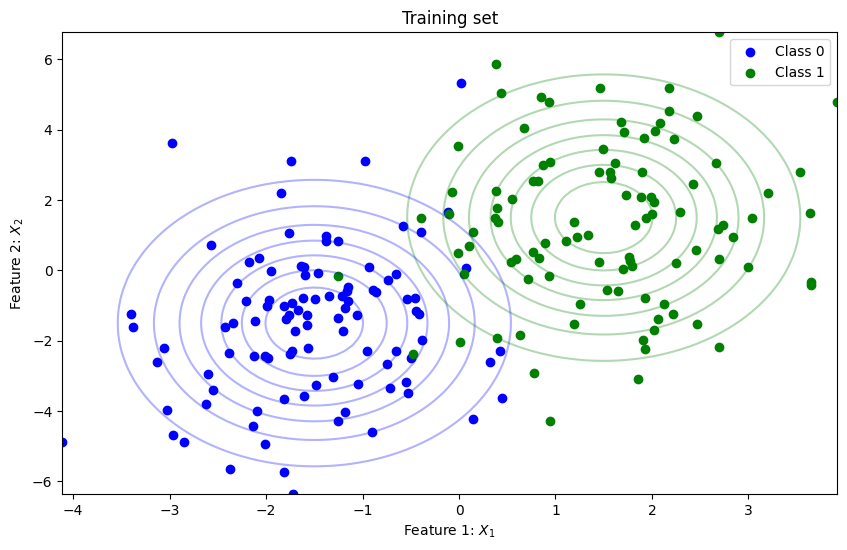

In [6]:
labels = {0: 'Class 0', 1: 'Class 1'}
label_colours = ['blue', 'green']

def plot_data(x, y, labels, colours):
    for c in np.unique(y):
        inx = np.where(y == c)
        plt.scatter(x[inx, 0], x[inx, 1], label=labels[c], c=colours[c])
    plt.title("Training set")
    plt.xlabel("Feature 1: $X_1$")
    plt.ylabel("Feature 2: $X_2$")
    plt.legend()
    
plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), multi_norm0.log_prob, 1, label_colours[0])
contour_plot((x0_min, x0_max), (x1_min, x1_max), multi_norm1.log_prob, 1, label_colours[1])
plt.show()

To formalize the current setting: we have two classes $Y\in \{0,1\}$ and two features $X_1$ and $X_2$ such that:
$$
\begin{aligned}
\mathbb{P}(Y=0) = 1-\mathbb{P}(Y=1) = p
\end{aligned}
$$
and,
$$
\begin{aligned}
\mathbb{P}(X_i=x_i | Y=c) &= N(x_i | \mu_{ic}, \sigma_{i})\\
&= \frac{1}{\sqrt{2\pi\sigma_{i}^2}} \exp\left\{-\frac{1}{2} \left(\frac{x_i - \mu_{ic}}{\sigma_{i}}\right)^2\right\}
\end{aligned}
$$
and
$$
\begin{aligned}
\mathbb{P}(X_1=x_1, X_2=x_2 | Y =c) = \mathbb{P}(X_1=x_1 | Y=c) \mathbb{P}(X_2=x_2 | Y=c)
\end{aligned}
$$

**Note that we consider a case where the variance of the features do not depend on the class which is different from what we did during the practical.**

## Question 1: code the Naive Bayes classifier

Here you should adapt the code used in the part [Naive Bayes classifier](https://github.com/mlelarge/icfp-ml/blob/main/solutions/01_NaivesBayes_Logistic.ipynb) in order to estimate the parameters $p, \mu_{10}, \mu_{11}, \sigma_1, \mu_{20}, \mu_{21}, \sigma_2$.

Hint: there is only a small modification to make in one of the functions from the practical.

In [16]:
from torch.distributions import Categorical

def get_prior(y):
    n = len(y)
    labels = np.unique(y)
    return Categorical(torch.tensor([np.sum(y == label)/n for label in labels]))

In [17]:
prior = get_prior(y_train)

In [18]:
from torch.distributions import MultivariateNormal, Independent

def get_class_conditionals(x, y):
    n_classes = len(np.unique(y))
    n_feat = x.shape[-1]
    loc = np.zeros((n_classes, n_feat))
    scale_diag = np.zeros((n_classes, n_feat, n_feat))
    for i in range(n_feat):
        for c_k in range(n_classes):
            loc[c_k, i] = np.mean(x[np.where(y == c_k), i])
            scale_diag[c_k, i, i] = np.var(x[np.where(y==c_k), i])
    distribution = Independent(
        MultivariateNormal(
            loc = torch.tensor(loc),
            covariance_matrix=torch.tensor(scale_diag),
        ), 0
    )
    return distribution

In [19]:
class_conditionals = get_class_conditionals(x_train, y_train)

If you used the same names as in the practical, the code below should work without any modification:

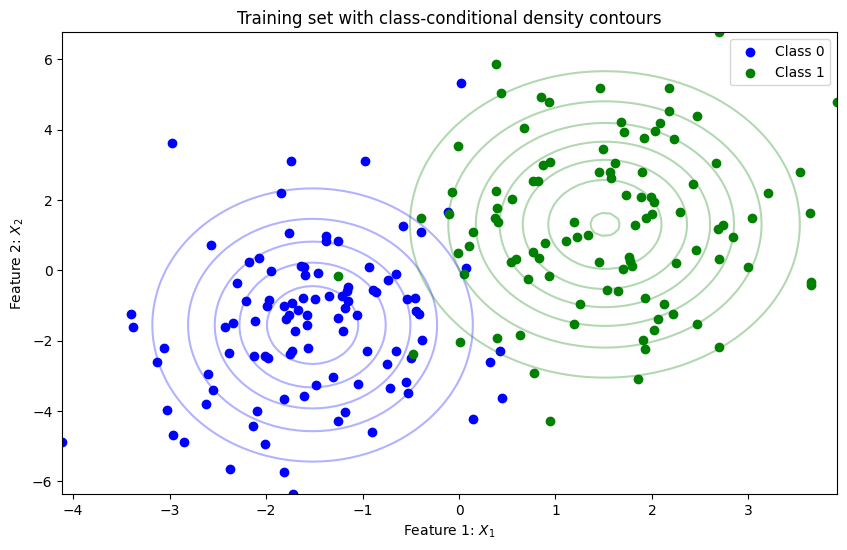

In [20]:
plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), class_conditionals.log_prob, 2, label_colours)
plt.title("Training set with class-conditional density contours")
plt.show()

In [24]:
def predict_class(prior, class_conditionals, x):
    """
    This function takes the prior distribution, class-conditional distribution, and 
    a batch of inputs in a numpy array of shape (batch_shape, 2).
    This function should compute the class probabilities for each input in the batch, using
    the prior and class-conditional distributions, according to the above equation.
    """
    class_probs = class_conditionals.log_prob(x[:, None])
    joint_likelihood = class_probs + torch.log(prior.probs).unsqueeze(0)
    norm_factor = torch.logsumexp(joint_likelihood, dim=-1, keepdims=True)
    log_prob = joint_likelihood - norm_factor
    y = torch.argmax(torch.exp(log_prob), dim=-1)
    return y

In [25]:
predictions = predict_class(prior, class_conditionals, torch.tensor(x_test))

In [26]:
accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: {:.4f}".format(accuracy))

Test accuracy: 0.9535


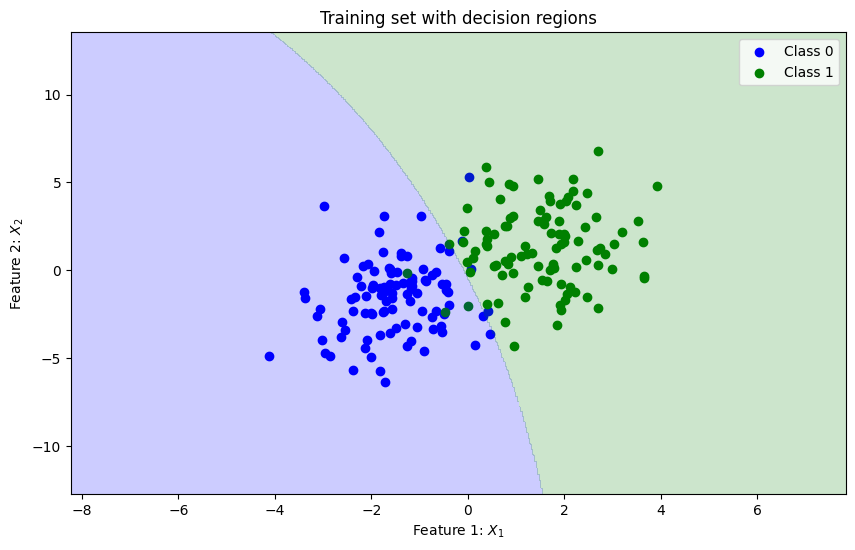

In [27]:
plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((2*x0_min, 2*x0_max), (2*x1_min, 2*x1_max), 
             lambda x: torch.log(predict_class(prior, class_conditionals, x)), 
             1, label_colours, levels=[-0.5, 0.5, 1.5, 2.5],
             num_points=500)
plt.title("Training set with decision regions")
plt.show()

## Question 2: plot the ROC curve corresponding to Naive Bayes

Hint: use [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) from the scikit-learn library. For this, you will need to first compute the likelihood from your Naive Bayes classifier.

In [ ]:
from sklearn.metrics import roc_curve

# your code

In [ ]:
# add the plot for Naive Bayes
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

## Logistic regression

We now consider another classifier with the logistic regression.
Here we can use directly the code from the practical as follows:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=-1)

epochs = 4000
input_dim = 2 # Two inputs x1 and x2 
output_dim = 2 
learning_rate = 0.005

model = LogisticRegression(input_dim,output_dim)

criterion = nn.NLLLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def train(model,criterion,optimizer,x_train,y_train,x_test,y_test,n_epochs=epochs,freq_print=200):
    losses = []
    losses_test = []
    Iterations = []
    total_test = y_test.size(0)
    total = y_train.size(0)
    iter = 0
    for epoch in range(n_epochs):
        outputs = model(x_train)
        
        loss = criterion(outputs.squeeze(), y_train) 
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
        optimizer.step() # Updates weights and biases with the optimizer (SGD)
        iter+=1
        if iter%freq_print==0:
            # calculate Accuracy
            with torch.no_grad():
                # Calculating the loss and accuracy for the test dataset
                outputs_test = torch.squeeze(model(x_test))
                loss_test = criterion(outputs_test, y_test)

                _,predicted_test = torch.max(outputs_test.data,1)
                correct_test = torch.sum(predicted_test == y_test.data)
                accuracy_test = 100 * correct_test/total_test
                losses_test.append(loss_test.item())
                
                # Calculating the loss and accuracy for the train dataset
                _,preds = torch.max(outputs.data,1)
                correct = torch.sum(preds == y_train.data)
                accuracy = 100 * correct/total
                losses.append(loss.item())
                Iterations.append(iter)

                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
    return losses, losses_test, Iterations

In [ ]:
dtype = torch.float32
x_trt = torch.tensor(x_train, dtype=dtype)
x_tst = torch.tensor(x_test, dtype=dtype)
y_trt = torch.tensor(y_train, dtype=torch.long)
y_tst = torch.tensor(y_test, dtype=torch.long)

losses, losses_test, Iterations = train(model,criterion,optimizer,x_trt,y_trt,x_tst,y_tst)

In [ ]:
plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
model.eval()
contour_plot((2*x0_min, 2*x0_max), (2*x1_min, 2*x1_max), 
             lambda x: torch.log(torch.argmax(model(x),-1)), 
             1, label_colours, levels=[-0.5, 0.5, 1.5, 2.5],
             num_points=500)
plt.title("Training set with decision regions")
plt.show()

## Question 3: plot the ROC curve corresponding to logistic regression

Normaly, you should be able to use the same function as the one used for the Naive Bayes ROC curve.

Plot the ROC curves for both classifiers on the same plot, what do you observe?

In [ ]:
# add both Naive Bayes and the logistic regression
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

## Question 4: computing the optimal ROC curve (Maths)

For this simple Gaussian mixture model, we can compute the optimal ROC curve.

Compute the loglikelihood ratio for $x=(x_1,x_2)\in \mathbb{R}^2$:
\begin{eqnarray*}
\ln\mathcal{L}(x) &=& \ln\frac{p(x|1)}{p(x|0)}
\end{eqnarray*}
and show that there exists $c,d_1,d_2\in \mathbb{R}$ such that $\ln\mathcal{L}(x) = c+d_1x_1+d_2x_2$.

Conclude that the optimal ROC curve is exactly the same ROC curve as the one computed for a mixture of $1$-dimensional Gaussian mixtures (studied in [Exact_ROC_GM](https://github.com/mlelarge/icfp-ml/blob/main/solutions/Exact_ROC_GM_sol.ipynb)) but for different values of the parameters. Give the expressions for these parameters.

## Question 5: plot the optimal ROC curve

Compute this ROC curve (feel free to use code from the practical) and superpose it with the ROC curves of the classifiers above.

In [ ]:
# your code

In [ ]:
# your 3 ROC curves
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), linestyle='--')
plt.legend();

## Question 6: Why all ROC curves agree? (Maths)

Give a short explanation of why the ROC curve of Naive Bayes agree with the optimla ROC curve.

Logistic regression assumes a [parametric form](https://dataflowr.github.io/slides/module3.html#16) for the distribution $p(y=1|x)=\sigma(b+w_1x_1+w_2x_2)$, where $\sigma(x)=1\frac{1}{1+e^{-x}}$ is the sigmoid function. The paramerters $b,w_1,w_2$ are computed through gradient descent to maximize the log-likelihood.
The fact that the ROC curves agree suggests that the parametric form of the logistic regression is correct for our Gaussian mixture model. Show that this is indeed the case by giving the values of $b, w_1$ and $w_2$ as a function of $p,\mu_{10}, \mu_{11}, \sigma_1,\mu_{20}, \mu_{21}, \sigma_2$.

Hint: 
$$
p(y=1|x)=\frac{1}{1+\frac{p(y=0)p(x|y=0)}{p(y=1)p(x|y=1)}}
$$

Conclude.